# EDA dataset Amazon's Top 50 bestselling books from 2009 to 2019
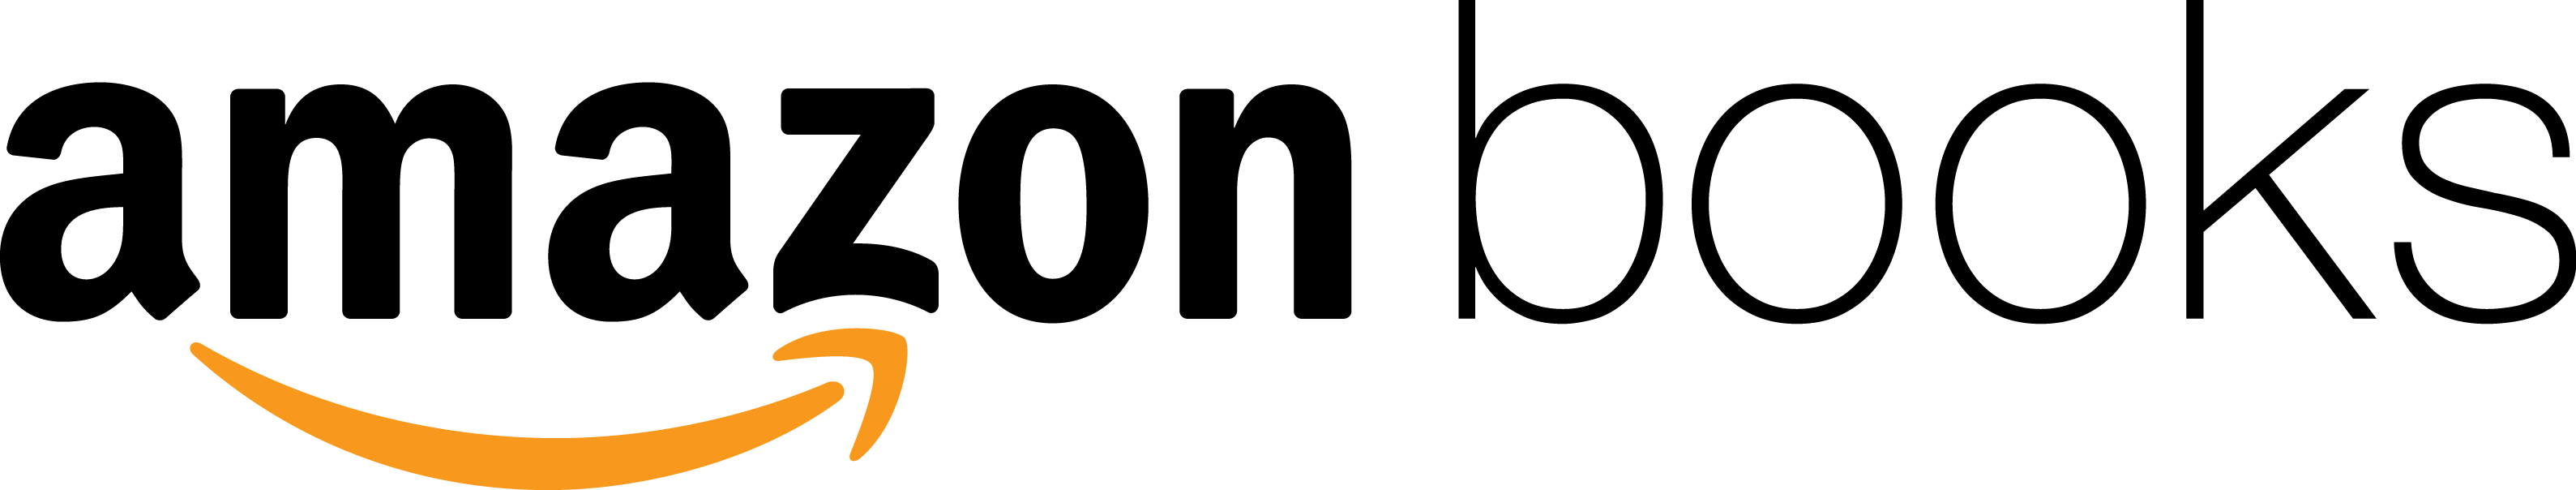

# Table of contents
1. **Introduction**
2. **Importing libraries**
3. **Data description and data cleaning**
4. **Testing hypothesis**
5. **Final conclusions**


# 1. Introduction of variables in dataset
* Name - Name of the Book
* Author - The author of the Book
* User Rating - Amazon User Rating
* Reviews - Number of written reviews on amazon
* Price - The price of the book (As at 13/10/2020)
* Year - The Year(s) it ranked on the bestseller
* Genre - Whether fiction or non-fiction

**The questions I'll answer**:
* Which author's books receive the highest average rating (top authors)
* Which author has written the most bestsellers (top authors)
* Which book has the most reviews (top books)
* Which genres become bestsellers more often
* Are genres different by rating

# 2. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import missingno
import fuzzywuzzy
from fuzzywuzzy import process
import collections
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

# 3. Data description and data cleaning

In [2]:
# Reading data
bestsellers = pd.read_csv('../input/amazon-top-50-bestselling-books-2009-2019/bestsellers with categories.csv') # Loading data
bestsellers.head() # Displaying the first 5 lines of the dataset

In [3]:
# Let's look at the dimension of the data
print(f'Data contaion {bestsellers.shape[0]} records and {bestsellers.shape[1]} columns.')

In [4]:
#Let's deduce data types
bestsellers.dtypes

Data contains 3 object columns and 4 columns contains numeric values. Let's convert the genre to the category data type.

In [5]:
#Change the data type
bestsellers.Genre=bestsellers.Genre.astype('category')
bestsellers.dtypes

Missing values
Let's calculate the percentage of blanks and filled values for all columns.

In [6]:
# loop through the columns and check the missing values
for col in bestsellers.columns:
    pct_missing=bestsellers[col].isnull().mean()
    print(f'{col}-{pct_missing :.1%}')

Visualizing missing values

In [7]:
#Build a matrix of missing values
missingno.matrix(bestsellers,fontsize=16)
plt.show()

**Conclusion:The data has no missing values, so no further transformations are required**

Duplicates

In [8]:
#Forming categorical columns
col_name_without_numeric_data=list(bestsellers.select_dtypes(exclude=('int','float')).columns)
print(f'Сolumns without numeric data: {", ".join(col_name_without_numeric_data)}.')

In [9]:
#Let's see the duplicates in the columns
for col in col_name_without_numeric_data:
    if bestsellers[col].duplicated().any()==True:
        print(f'Column {col} contains duplicates.')
    else:
        print(f'Column {col} does not contain duplicates')

Check if the columns contains words in different case and extra spaces.

In [10]:
#check if spelling errors have been hit
for col in col_name_without_numeric_data:
    print(f'Before {col}:{len(set(bestsellers[col]))} After {col}: {len(set(bestsellers[col].str.title().str.strip()))}')

Indeed, there were typing errors in the Name column. Let's fix it.

In [11]:
#Correct the errors
bestsellers.Name=bestsellers.Name.str.title().str.strip()

In [12]:
#Check
for col in col_name_without_numeric_data:
    print(f'Before {col}: {len(set(bestsellers[col]))} After {col}: {len(set(bestsellers[col].str.title().str.strip()))}')

Let's check if there are the same author names but with different spellings.

In [13]:
#Check the column Author
authors=bestsellers.Author.sort_values().unique()
authors

Names of authors George R. R. Martin, George R.R. Martin and J. K. Rowling, J.K. Rowling have different spellings although they are the same authors. Let's fix it.

In [14]:
#Replace the Author name 
bestsellers=bestsellers.replace('George R. R. Martin', 'George R.R. Martin')
bestsellers=bestsellers.replace('J. K. Rowling', 'J.K. Rowling')

In [15]:
#Check
for col in col_name_without_numeric_data:
    print(f'Before {col}: {len(set(bestsellers[col]))} After {col}: {len(set(bestsellers[col].str.title().str.strip()))}')

In [16]:
#Check the column Genre
genre=bestsellers.Genre.unique()
genre

Genre is fine

In [17]:
#Check the column Year
years=list(bestsellers.Year.unique())
sorted(years)

Everything is fine with years.

In addition, there may be duplicate rows in the data. Let's display the last 5 lines of the dataframe.



In [18]:
#Display the last 5 lines
bestsellers.tail()

In addition, it is worth noting that there are duplicate rows in the data, but with different years. Let's remove duplicates. Let's leave the data without years for later analysis.

In [19]:
#Delete the year column
del bestsellers['Year']

In [20]:
#Remove duplicates and check how many books are left in the data
bestsellers=bestsellers.drop_duplicates(keep='first')
bestsellers.info()

Find the reason why duplication occurs.

In [21]:
#Count the number of each book in the data
count_books=collections.Counter(bestsellers.Name.tolist())
print(count_books.most_common(11))

Сheck with the example of a book The Help

In [22]:
#Display information on the book 'The Help'
bestsellers[bestsellers['Name']=='The Help']

Records are duplicated by price. Apparently, in different years the book costs differently, which is quite logical taking into account inflation, demand, etc. Let's leave only the last entries.

In [23]:
#Drop duplicates
bestsellers=bestsellers.drop_duplicates(subset='Name',keep='last')
bestsellers

**Conclusion:Thus, the data contains 350 different books written by 246 authors. All books are presented in two categories (Non Fiction, Fiction)**

**In this section, we will analyze categorical data and answer the following questions:**

1. Which author's books receive the highest average rating (top authors).
2. Which author has written the most bestsellers (top authors).
3. Which genres become bestsellers more often.
4. Which book has the most reviews (top books)

Let's create new dataframes based on the average rating of authors, the number of books written by authors, the number of reviews for books and the number of books by genre. We visualize the received information.



In [24]:
#We take all authors with the highest average rating
top_13_authors=bestsellers.groupby('Author')[['User Rating']].mean().sort_values('User Rating', ascending=False).head(13).reset_index()

#Authors who have written the most bestsellers
number_of_books_written=bestsellers.groupby('Author')[['Name']].count().sort_values('Name', ascending=False).head(10).reset_index()

# We take books with the number of reviews
books_with_the_number_of_reviews = bestsellers.groupby('Name')[['Reviews']].sum().sort_values('Reviews', ascending=False).head(5).reset_index()

# We take the number of books by genre
number_of_books_by_genre = bestsellers.groupby('Genre')[['Name']].count().sort_values('Name', ascending=False).head(10).reset_index()

In [25]:
#Setting the visualization parameters
fig_1=make_subplots(rows=1,cols=1,subplot_titles=(''))#set the number of rows and columns

#Setting table parameters
fig_1.add_trace(go.Table(columnorder=[1,2],columnwidth=[100,50],
                         header=dict(values=top_13_authors.columns,
                                     line_color='darkslategray',
                                     fill_color='Salmon',
                                     height=30),
                         cells=dict(values=[top_13_authors['Author'],
                                    top_13_authors['User Rating']], 
                                    line_color='darkslategray',
                                    fill_color='White')))
# Setting the parameters of the chart 
fig_1.update_layout(showlegend=False, 
                    title_text='Top 13 best authors', 
                    title_font_size=16, 
                    title_font_family='Arial', 
                    title_x=0.5,
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))
# Displaying the graph
fig_1.show()

# Let's set the visualization parameters
fig_2 = make_subplots(rows=1, cols=2,
                      specs=[[{'type': 'xy'}, {"type": "xy"}]],
                      subplot_titles=("Top 10 authors by number of bestsellers", 
                                      "Top 5 books by number of reviews"))
# Setting Bar parameters
fig_2.add_trace(go.Bar(x=number_of_books_written['Author'], 
                       y=number_of_books_written['Name'],
                       name ='Count books',
                       marker_color=['#ff6666','#f76e6e', '#f07575', '#e87d7d', '#e08585',
                                     '#d98c8c', '#d19494', '#c99c9c', '#c2a3a3', '#baabab']),
                       row=1, col=1)

# Setting Bar parameters
fig_2.add_trace(go.Bar(x=books_with_the_number_of_reviews['Name'], 
                       y=books_with_the_number_of_reviews['Reviews'],
                       marker_color=['#ff6666','#f47171', '#e87d7d', '#dd8888', '#d19494'],
                       name ='Reviews'),
                       row=1, col=2)

# Setting the parameters of the chart when displaying
fig_2.update_traces(marker_line_color='Gray',
                    marker_line_width=1)

# Setting the parameters of the chart when displaying
fig_2.update_layout(showlegend=False, 
                    plot_bgcolor='rgba(0,0,0,0)',
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the graph
fig_2.show()

# Let's set the visualization parameters
fig_3 = make_subplots(rows=1, cols=1,
                      specs=[[{'type': 'domain'}]],
                      subplot_titles=(""))
# Setting Pie parameters
fig_3.add_trace(go.Pie(values=number_of_books_by_genre['Name'],
                       title='Genre',
                       labels=['Non Fiction', 'Fiction'],
                       textinfo='label+percent',
                       insidetextorientation='radial',
                       hole=0.3,
                       marker=dict(colors=['Gray','Salmon'], 
                                   line_color='Gray', 
                                   line_width=1),
                       textfont={'color': '#FFFFFF', 'size': 12},
                       textfont_size=12))

# Setting the parameters of the chart when displaying
fig_3.update_layout(margin_t=30, 
                    showlegend=False, 
                    title_text='Count of books genre', 
                    title_x=0.5, 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the graph
fig_3.show()

**INSIGHT: By analyzing the categorical data, it is established:**

1. The following 13 authors have the highest rating: Nathan W. Pyle, Patrick Thorpe, Eric Carle, Emily Winfield Martin, Chip Gaines, Jill Twiss, Rush Limbaugh, Sherri Duskey Rinker, Alice Schertle, Pete Souza, Sarah Young, Lin-Manuel Miranda, Bill Martin Jr., Dav Pilkey. The average rating for their works was 4.9. When buying a new book, you should pay attention to these authors.
2. Authors who have written more bestsellers: Jeff Kinney - 12 books, Rick Riordan - 10 books, J.K. Rowling - 8 books, Stephenie Meyer - 7 books, Dav Pilkey - 6 books, Bill O'Reilly - 6 books, John Grisham - 5 books, E L James - 5 books, Suzanne Collins - 5 books, Charlaine Harris - 4 books. These authors always have something to read.
3. Books with the most reviews: Where The Crawdads Sing - 87841 Reviews, The Girl On The Train - 79446 Reviews, Becoming - 61133 Reviews, Gone Girl - 57271 Reviews, The Fault In Our Stars - 50482 Reviews. It's definitely worth reading the book Where The Crawdads Sing, it's not for nothing that it is the most talked about.
4. Non-fiction is more likely to become a bestseller. Later we will find out how users relate to these genres.

For numeric data

Let's look at the measures of the central trend that characterize the distribution of numerical values in the data. We render a box-plot for each numeric variable.

In [26]:
#Display measures of the central trend
bestsellers.describe().T

In [27]:
# Let's set the visualization parameters
fig_4 = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Box parameters
fig_4.add_trace(go.Box(x=bestsellers['User Rating'], 
                       name='User Rating'))

# Setting the parameters of the Box when displaying
fig_4.update_traces(marker_color='Salmon')

# Setting the parameters of the Box when displaying
fig_4.update_layout(showlegend=False, 
                    template='simple_white', 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))
# Displaying the Box
fig_4.show()

# Let's set the visualization parameters
fig_5 = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Box parameters
fig_5.add_trace(go.Box(x=bestsellers['Reviews'], 
                       name='Reviews'))

# Setting the parameters of the Box when displaying
fig_5.update_traces(marker_color='Salmon')

# Setting the parameters of the Box when displaying
fig_5.update_layout(showlegend=False, 
                    template='simple_white', 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))
# Displaying the Box
fig_5.show()

# Let's set the visualization parameters
fig_6 = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Box parameters
fig_6.add_trace(go.Box(x=bestsellers['Price'], 
                       name='Price'))

# Setting the parameters of the Box when displaying
fig_6.update_traces(marker_color='Salmon')

# Setting the parameters of the Box when displaying
fig_6.update_layout(showlegend=False, 
                    template='simple_white', 
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))
# Displaying the Box
fig_6.show()


**INSIGHT: By analyzing the numeric data, it is established:**

**User Rating:**
1. Data is not distributed normally. Asymmetry is observed.
2. Average and median book ratings are 4.6.
3. There are outliers in the data. There are a small number of books in the data below the 4.1 rating.

**Reviews:**
1. Data is not distributed normally. Asymmetry is observed.
2. The data has a wide range.
3. There are outliers in the data. There are a small number of books receiving reviews well above the 75 percentile.

**Price:**
1. Data is not distributed normally. Asymmetry is observed.
2. There are books that cost much higher than the average, as well as books with a cost of 0, which is strange.Either the book is given for free or this error.

Let's look at the correlation in the data.

In [28]:
# Building a correlation matrix and building a correlation matrix and visualizing relationships
bestsellers.corr()

In [29]:
# Let's set the visualization parameters
fig_7 = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Scatter parameters
fig_7.add_trace(go.Scattergl(x=bestsellers['User Rating'],
                             y=bestsellers['Reviews'],
                             mode='markers',
                             marker_color='salmon'))

# Setting the parameters of the Scatter when displaying
fig_7.update_layout(template='simple_white',
                    showlegend=False, 
                    xaxis = {'title':'User Rating'}, 
                    yaxis = {'title':'Reviews'},
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the Scatter
fig_7.show()

# Let's set the visualization parameters
fig_8 = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Scatter parameters
fig_8.add_trace(go.Scattergl(x=bestsellers['User Rating'],
                             y=bestsellers['Price'],
                             mode='markers',
                             marker_color='salmon'))

# Setting the parameters of the Scatter when displaying
fig_8.update_layout(template='simple_white',
                    showlegend=False,
                    xaxis = {'title':'User Rating'}, 
                    yaxis = {'title':'Price'},
                    font=dict(family='Arial', 
                              size=12, 
                              color='black'))

# Displaying the Scatter
fig_8.show()

# Let's set the visualization parameters
fig_9 = make_subplots(rows=1, cols=1, specs=[[{'type': 'xy'}]])

# Setting Scatter parameters
fig_9.add_trace(go.Scattergl(x=bestsellers['Price'],
                             y=bestsellers['Reviews'],
                             mode='markers',
                             marker_color='salmon'))

# Setting the parameters of the Scatter when displaying
fig_9.update_layout(template='simple_white',
                    showlegend=False, 
                    xaxis = {'title':'Price'}, 
                    yaxis = {'title':'Reviews'},
                    font=dict(family='Arial', size=12, color='black'))

# Displaying the Scatter
fig_9.show()

**INSIGHT**: Based on the constructed correlation matrix as well as the constructed visualizations, it can be seen that the data does not contain any positive or negative linear relationship between the rating, reviews and the price of books.

# 4.TESTING HYPOTHESES

Now I want to test the following hypothesis: "**Do genres differ in terms of rating?**"

We will test the hypothesis according to the following algorithm:

1. Null and alternative hypotheses are formulated.
2. The distribution was checked for normality using "Shapiro Wilk test of normality".
3. Two samples were formed. Books related to the Non Fiction genre and books related to the Fiction genre.
4. Testing was carried out in order to identify statistical differences between the study groups.

Let us formulate the null and alternative hypotheses.

H0 - There are no differences between genre rating

H1 - There are differences between genre rating

In [30]:
#Checking the distribution for normality. Using "Shapiro Wilk test of normality"
#Set the alpha level
alpha=0.05

#We pass groups to the criterion for testing
stat,pval=shapiro(bestsellers['User Rating'])

print('Statistic:', f'{stat:.3f}')
print('P-Value:',f'{pval:.20f}')

#Checking the condition for accepting or rejecting H0
if pval>alpha:
    print('Accept H0 - Data is distributed normally.')
if pval<alpha:
    print('Reject H0 - Data is not distributed normally.')

Let's form two samples for testing

In [31]:
#Create group
non_fiction=bestsellers[bestsellers['Genre']=='Non Fiction']['User Rating']
fiction=bestsellers[bestsellers['Genre']=='Fiction']['User Rating']

Let's carry out testing. Since the data in the samples are not normally distributed, we will use the nonparametric Mann-Whitney test

In [32]:
# Set the alpha level
alpha=0.05

# We pass groups to the criterion for testing
stat, pval = mannwhitneyu(non_fiction, fiction)

print('Statistic:', f'{stat:.3f}')
print('P-Value:', f'{pval:.20f}')
 
# Checking the condition for accepting or rejecting H0
if pval > alpha:
    print('Accept H0 - There is no significant difference between the groups.')
if pval < alpha:
    print('Reject H0 - There are significant differences between the groups.')

Let's compare the median values in the groups

In [33]:
print(f'Non_fiction median: {non_fiction.median()}, Fiction median: {fiction.median()}')

Visualizing the density of distribution in samples

In [34]:
# Create distplot with curve_type set to 'normal'
fig_10 = ff.create_distplot([non_fiction, fiction], 
                         ['Non_fiction', 'Fiction'], 
                         colors=['salmon', 'gray',],
                         bin_size=.1, 
                         show_rug=False)

# Add title
fig_10.update_layout(title_text='Сomparison of the distribution density in the group Non_fiction and the group', 
                     template='simple_white',
                     font=dict(family='Arial', size=12, color='black'))
fig_10.show()

**INSIGHT**: As a result of the testing, statistically significant differences were obtained between the compared groups. Based on the results obtained, it can be argued that users evaluate books differently depending on the genre, and based on the median values, readers give preference to works of fiction.

# 5.Final Conclusions

* The following 13 authors have the highest rating: Nathan W. Pyle, Patrick Thorpe, Eric Carle, Emily Winfield Martin, Chip Gaines, Jill Twiss, Rush Limbaugh, Sherri Duskey Rinker, Alice Schertle, Pete Souza, Sarah Young, Lin-Manuel Miranda, Bill Martin Jr., Dav Pilkey. The average rating for their works was 4.9. When buying a new book, you should pay attention to these authors.
* Authors who have written more bestsellers: Jeff Kinney - 12 books, Rick Riordan - 10 books, J.K. Rowling - 8 books, Stephenie Meyer - 7 books, Dav Pilkey - 6 books, Bill O'Reilly - 6 books, John Grisham - 5 books, E L James - 5 books, Suzanne Collins - 5 books, Charlaine Harris - 4 books. These authors always have something to read.
* Books with the most reviews: Where The Crawdads Sing - 87841 Reviews, The Girl On The Train - 79446 Reviews, Becoming - 61133 Reviews, Gone Girl - 57271 Reviews, The Fault In Our Stars - 50482 Reviews. It's definitely worth reading the book Where The Crawdads Sing, it's not for nothing that it is the most talked about.
* Non-fiction is more likely to become a bestseller. Later we will find out how users relate to these genres.
* User Rating:
  * Data is not distributed normally. Asymmetry is observed.
  * Average and median book ratings are 4.6.
  * There are outliers in the data. There are a small number of books in the data below the 4.1 rating.
* Reviews:
  * Data is not distributed normally. Asymmetry is observed.
  * The data has a wide range.
  * There are outliers in the data. There are a small number of books receiving reviews well above the 75 percentile.
* Price:
  * Data is not distributed normally. Asymmetry is observed.
  * There are books that cost much higher than the average, as well as books with a cost of 0, which is strange.Either the book is given for free or this error.
* Based on the constructed correlation matrix as well as the constructed visualizations, it can be seen that the data does not contain any positive or negative linear relationship between the rating, reviews and the price of books
* As a result of the testing, statistically significant differences were obtained between the compared groups. Based on the results obtained, it can be argued that users evaluate books differently depending on the genre, and based on the median values, readers give preference to works of fiction